In [1]:
import os
from typing import Any, Dict, Tuple
import numpy as np
import pandas as pd
import json
from ast import literal_eval as make_tuple

from utils.error_metrics import MulticlassErrorMetrics, DatasetCategory

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold


def get_dataset_with_dependend_variabels(
    df_set: pd.DataFrame, df_dependent: pd.DataFrame
) -> pd.DataFrame:
    df = df_set[
        ["Date", "Area", "mapped_hazard_forecast", "mapped_hazard_observed"]
    ].copy()
    df["Date"] = pd.to_datetime(df["Date"]).dt.date
    df_dependent["Date"] = pd.to_datetime(df_dependent["Date"]).dt.date
    df = df.merge(df_dependent, on=["Date", "Area"])
    return df


def xy_split(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    return (
        df.drop(
            columns=["Date", "Area", "mapped_hazard_forecast", "mapped_hazard_observed"]
        ),
        df["mapped_hazard_forecast"],
    )


def fit_and_compute_errors(
    errs: MulticlassErrorMetrics,
    independent_variables_and_sets: Tuple[str, Dict[DatasetCategory, pd.DataFrame]],
    model_name_and_pipeline: Tuple[str, Pipeline],
):
    independent_variables = independent_variables_and_sets[0]
    sets = independent_variables_and_sets[1]
    model_name = model_name_and_pipeline[0]
    pipe = model_name_and_pipeline[1]

    training_set = sets[DatasetCategory.TRAINING]
    x, y = xy_split(training_set)
    pipe.fit(x, y)

    for ds_type, ds in sets.items():
        x, _ = xy_split(ds)
        y_pred = pipe.predict(x)
        errs.compute_errors(model_name, independent_variables, ds_type, y_pred)


def params_to_file(file_name: str, params: Dict[str, Any]) -> None:
    with open(f"../data/aux/params/{file_name.replace(".*","")}.json", "w") as f:
        json.dump(params, f)


def params_from_file(file_name: str) -> Dict[str, Any]:
    file_name = f"../data/aux/params/{file_name.replace(".*","")}.json"
    if not os.path.exists(file_name):
        raise FileNotFoundError(f"The file {file_name} does not exist.")
    with open(file_name, "r") as f:
        d = json.load(f)
        hidden_layer_sizes = d.get("hidden_layer_sizes", None)
        if not hidden_layer_sizes is None:
            d["hidden_layer_sizes"] = make_tuple(hidden_layer_sizes)
        return d

In [2]:
df_train = pd.read_csv("../data/processed/SAIS_train.csv", index_col=0)
df_test = pd.read_csv("../data/processed/SAIS_test.csv", index_col=0)

df_tab = pd.read_csv("../data/processed/SAIS_tabularised.csv", index_col=0)

df_train_tab = df_tab.loc[df_train.index]
df_test_tab = df_tab.loc[df_test.index]

df_weather_data_daily_tab = pd.read_csv(
    "../data/proprietary/weather/visual_crossing/weather_observed_days_tabularised.csv"
)
df_weather_data_48h_then_daily_tab = pd.read_csv(
    "../data/proprietary/weather/visual_crossing/weather_observed_tabularised_48_hours_then_days.csv"
)

snowprofiles = (
    "snow profiles",
    {
        DatasetCategory.TRAINING: df_train,
        DatasetCategory.TEST: df_test,
    },
)

snowprofiles_whole_season = (
    "snow profiles across season",
    {
        DatasetCategory.TRAINING: df_train_tab,
        DatasetCategory.TEST: df_test_tab,
    },
)

weather_daily_whole_season = (
    "weather daily data across season",
    {
        DatasetCategory.TRAINING: get_dataset_with_dependend_variabels(
            df_train, df_weather_data_daily_tab
        ),
        DatasetCategory.TEST: get_dataset_with_dependend_variabels(
            df_test, df_weather_data_daily_tab
        ),
    },
)

weather_48h_then_daily_season = (
    "weather 48h hourly then daily data across season",
    {
        DatasetCategory.TRAINING: get_dataset_with_dependend_variabels(
            df_train, df_weather_data_48h_then_daily_tab
        ),
        DatasetCategory.TEST: get_dataset_with_dependend_variabels(
            df_test, df_weather_data_48h_then_daily_tab
        ),
    },
)

In [3]:
most_frequent_value = df_train["mapped_hazard_forecast"].value_counts().index[0]

errs_summary = MulticlassErrorMetrics(
    dataset_name="sais",
    classes=sorted(df_train["mapped_hazard_forecast"].unique()),
    y_true_train=df_train["mapped_hazard_forecast"],
    y_true_dev=None,
    y_true_test=df_test["mapped_hazard_forecast"],
)

run = lambda model, data: fit_and_compute_errors(
    errs=errs_summary,
    independent_variables_and_sets=data,
    model_name_and_pipeline=model,
)

model_name_const = "const"
errs_summary.compute_errors_all_sets(
    model_name_const,
    None,
    most_frequent_value,
    None,
    most_frequent_value,
)
model_name_obs = "observed"
errs_summary.compute_errors_all_sets(
    model_name_obs,
    None,
    df_train["mapped_hazard_observed"],
    None,
    df_test["mapped_hazard_observed"],
)

scaler = StandardScaler()
softmax = (
    "softmax",
    Pipeline(
        [
            ("scaler", scaler),
            ("model", LogisticRegression(random_state=1, max_iter=int(1e4))),
        ]
    ),
)

random_forest = (
    "random forest",
    Pipeline(
        [
            ("scaler", scaler),
            ("model", RandomForestClassifier(random_state=1, warm_start=True)),
        ]
    ),
)

random_forest_tuned = (
    "random forest (tuned)",
    Pipeline(
        [
            ("scaler", scaler),
            (
                "model",
                RandomForestClassifier(random_state=1).set_params(
                    **params_from_file("random_forest_tuned")
                ),
            ),
        ]
    ),
)

mlp = (
    "MLP",
    Pipeline(
        [
            ("scaler", scaler),
            ("model", MLPClassifier(random_state=1, early_stopping=True)),
        ]
    ),
)


mlp_tuned = (
    "MLP (tuned)",
    Pipeline(
        [
            ("scaler", scaler),
            (
                "model",
                MLPClassifier(random_state=1, early_stopping=True).set_params(
                    **params_from_file("mlp_tuned")
                ),
            ),
        ]
    ),
)

In [4]:
run(softmax, snowprofiles)

run(softmax, snowprofiles_whole_season)

run(softmax, weather_daily_whole_season)

run(softmax, weather_48h_then_daily_season)

run(random_forest, weather_48h_then_daily_season)

run(mlp, weather_48h_then_daily_season)

run(random_forest_tuned, weather_48h_then_daily_season)

run(mlp_tuned, weather_48h_then_daily_season)

errs_summary.save_assets()

errs_summary.get_error_table_for_set(DatasetCategory.TEST)

/Users/witold/Repos/witgaw/avalanche-danger-level-forecast/.venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(


,MSE,average error,highest error,accuracy,precision (multiclass),precision (macro),recall (multiclass),recall (macro),$F_1$ (multiclass),$F_1$ (macro),confusion matrix
"const, None",1.62786,-0.893747,-2,0.328419,"[0.0, 0.0, 0.33, 0.0]",0.082105,"[0.0, 0.0, 1.0, 0.0]",0.25,"[0.0, 0.0, 0.49, 0.0]",0.123613,"[[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0], [..."
"observed, None",0.300458,0.146924,3,0.758516,"[0.76, 0.69, 0.84, 0.67]",0.738307,"[0.93, 0.66, 0.73, 0.42]",0.686051,"[0.84, 0.67, 0.78, 0.52]",0.702249,"[[0.9266347687400319, 0.0733652312599681, 0.0,..."
"softmax, snow profiles",0.526182,0.071683,3,0.608541,"[0.68, 0.48, 0.62, 0.36]",0.533047,"[0.8, 0.35, 0.75, 0.05]",0.486607,"[0.73, 0.4, 0.68, 0.09]",0.476224,"[[0.7974481658692185, 0.16108452950558214, 0.0..."
"softmax, snow profiles across season",0.716828,-0.006101,3,0.526182,"[0.64, 0.41, 0.58, 0.22]",0.463045,"[0.64, 0.41, 0.56, 0.27]",0.471085,"[0.64, 0.41, 0.57, 0.25]",0.46633,"[[0.6411483253588517, 0.2822966507177033, 0.07..."
"softmax, weather daily data across season",0.614133,-0.020336,3,0.575496,"[0.69, 0.45, 0.61, 0.42]",0.545248,"[0.66, 0.48, 0.61, 0.44]",0.545899,"[0.68, 0.47, 0.61, 0.43]",0.545317,"[[0.6570972886762361, 0.2647527910685805, 0.07..."
"softmax, weather 48h hourly then daily data across season",0.647178,0.021861,3,0.565836,"[0.67, 0.45, 0.59, 0.45]",0.539052,"[0.68, 0.46, 0.58, 0.39]",0.527165,"[0.68, 0.45, 0.58, 0.42]",0.532588,"[[0.6810207336523126, 0.23763955342902712, 0.0..."
"random forest, weather 48h hourly then daily data across season",0.365531,0.038129,3,0.699542,"[0.79, 0.62, 0.68, 0.83]",0.729025,"[0.82, 0.55, 0.79, 0.16]",0.58229,"[0.81, 0.58, 0.73, 0.27]",0.596466,"[[0.8245614035087719, 0.1371610845295056, 0.03..."
"MLP, weather 48h hourly then daily data across season",0.493137,-0.002034,-3,0.652771,"[0.72, 0.59, 0.63, 0.61]",0.638481,"[0.78, 0.44, 0.77, 0.35]",0.584689,"[0.75, 0.5, 0.7, 0.44]",0.597647,"[[0.7830940988835726, 0.13556618819776714, 0.0..."
"random forest (tuned), weather 48h hourly then daily data across season",0.345196,0.009659,2,0.70666,"[0.81, 0.61, 0.69, 0.77]",0.718223,"[0.83, 0.55, 0.78, 0.39]",0.63701,"[0.82, 0.58, 0.73, 0.52]",0.660717,"[[0.8261562998405104, 0.1467304625199362, 0.02..."
"MLP (tuned), weather 48h hourly then daily data across season",0.408236,0.031012,3,0.67514,"[0.77, 0.56, 0.7, 0.6]",0.656521,"[0.78, 0.57, 0.7, 0.45]",0.626611,"[0.77, 0.57, 0.7, 0.51]",0.639042,"[[0.7814992025518341, 0.17862838915470494, 0.0..."


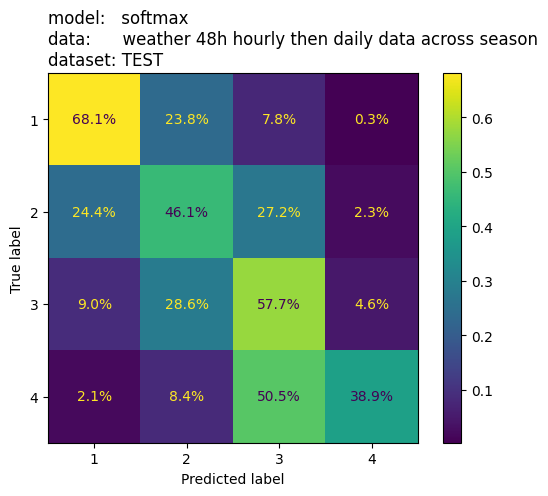

In [5]:
errs_summary.show_confusion_matrix(
    model_name=softmax[0],
    independent_variables=weather_48h_then_daily_season[0],
    set_cat=DatasetCategory.TEST,
)

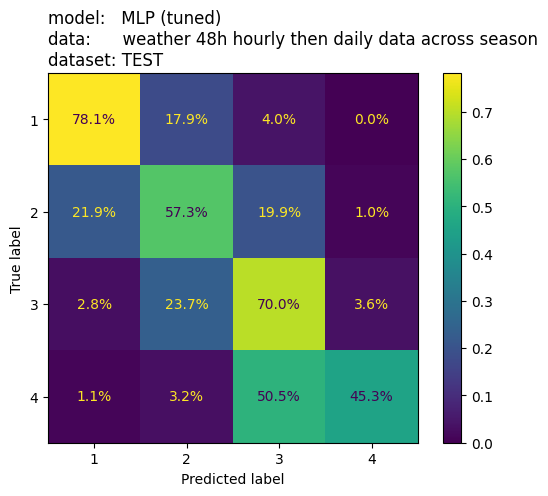

In [6]:
errs_summary.show_confusion_matrix(
    model_name=mlp_tuned[0],
    independent_variables=weather_48h_then_daily_season[0],
    set_cat=DatasetCategory.TEST,
)

## Hyperparameter tuning

In [7]:
rerun_softmax = False
rerun_random_forest = False
rerun_mlp = False

# long running
if rerun_softmax:
    grid = {
        "model__penalty": ["l1", "l2", "elasticnet", None],
        "model__tol": [1e-2, 1e-4, 1e-6],
        "model__C": [1e-3, 1e-2, 1e-1, 1],
        "model__fit_intercept": [False, True],
        "model__solver": ["lbfgs", "newton-cg", "sag", "saga"],
        "model__class_weight": [
            "balanced",
            "balanced_subsample",
            {1: 0.1, 2: 0.3, 3: 0.1, 4: 0.5},
            {1: 0.01, 2: 0.45, 3: 0.09, 4: 0.45},
        ],
    }
    random_search_softmax = RandomizedSearchCV(
        estimator=softmax[1],
        n_jobs=-1,
        cv=RepeatedKFold(n_splits=10, n_repeats=3, random_state=1),
        param_distributions=grid,
        scoring="f1_macro",
        n_iter=20,
    )

    run(
        ("softmax (tuned)", random_search_softmax),
        weather_48h_then_daily_season,
    )
    params_to_file(
        "softmax_tuned", random_search_softmax.best_estimator_["model"].get_params()
    )

# long running
if rerun_random_forest:
    # Followed approach in: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
    grid = {
        "model__n_estimators": [
            int(x) for x in np.linspace(start=200, stop=2000, num=10)
        ],
        "model__criterion": ["gini", "entropy", "log_loss"],
        "model__max_features": [None, "auto", "sqrt"],
        "model__max_depth": [None] + [int(x) for x in np.linspace(10, 110, num=11)],
        "model__min_samples_split": [2, 5, 10, 50],
        "model__min_samples_leaf": [1, 2, 4],
        "model__bootstrap": [True, False],
        "model__class_weight": [
            "balanced",
            "balanced_subsample",
            {1: 0.1, 2: 0.3, 3: 0.1, 4: 0.5},
            {1: 0.01, 2: 0.45, 3: 0.09, 4: 0.45},
        ],
    }
    random_search_random_forrest = RandomizedSearchCV(
        estimator=random_forest[1],
        n_jobs=-1,
        cv=RepeatedKFold(n_splits=10, n_repeats=3, random_state=1),
        param_distributions=grid,
        scoring="f1_macro",
        n_iter=20,
    )

    run(
        ("random forrest (tuned)", random_search_random_forrest),
        weather_48h_then_daily_season,
    )
    params_to_file(
        "random_forest_tuned",
        random_search_random_forrest.best_estimator_["model"].get_params(),
    )


# long running
if rerun_mlp:

    grid = {
        "model__hidden_layer_sizes": [
            (100,),
            (1000,),
            (100, 300, 100),
            (10, 30, 10),
            (20,),
        ],
        "model__activation": ["relu", "logistic", "tanh"],
        "model__solver": ["sgd", "adam"],
        "model__alpha": [0.0001, 0.001, 0.01],
        "model__learning_rate": ["constant", "invscaling", "adaptive"],
        "model__momentum": [0.1, 0.5, 0.9],
    }

    random_search_mlp = RandomizedSearchCV(
        estimator=mlp[1],
        n_jobs=-1,
        cv=RepeatedKFold(n_splits=10, n_repeats=3, random_state=1),
        param_distributions=grid,
        scoring="f1_macro",
        n_iter=20,
    )

    run(("MLP (tuned)", random_search_mlp), weather_48h_then_daily_season)
    params_to_file("mlp_tuned", random_search_mlp.best_estimator_["model"].get_params())